### **Notebook to make predictions with reprocessed Yoneda data and SPOT** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_yoneda_set3_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [12]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14400,Biodesign_Yoneda_set3_reprocessed,15006,EVOL33-LN-G-R1,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15030,EVOL33-LN-G-R1,NaN,WP_000104864_1,0,FPKM,0.0,14.0
1,14400,Biodesign_Yoneda_set3_reprocessed,15007,EVOL33-LN-G-R2,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15031,EVOL33-LN-G-R2,NaN,WP_000104864_1,0,FPKM,0.0,14.0
2,14400,Biodesign_Yoneda_set3_reprocessed,15008,EVOL33-LN-G-R3,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15032,EVOL33-LN-G-R3,NaN,WP_000104864_1,0,FPKM,0.0,14.0
3,14400,Biodesign_Yoneda_set3_reprocessed,14991,EVOL33-LN-LP-R1,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15015,EVOL33-LN-LP-R1,NaN,WP_000104864_1,0,FPKM,0.0,24.0
4,14400,Biodesign_Yoneda_set3_reprocessed,14992,EVOL33-LN-LP-R2,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15016,EVOL33-LN-LP-R2,NaN,WP_000104864_1,0,FPKM,0.0,24.0


##### **Load Genome Scale Model**

In [5]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import SPOT Code**

In [6]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [7]:
#Function to construct df from EFLUX2 functions: Needs to be modified for multiple time points!!!!!
def construct_trans_df(transdata, linename):
    transdataWTPR1 = transdata[transdata['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **SPOT Predictions**

In [15]:
#Function for EFLUX2 and SPOT Predictions:
def spot_pred(model, transcriptdf, linename, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
    return spotsol

In [16]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spot_pred_for_three_reps(model, transcriptdf, linename1, linename2, linename3, substrate):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = construct_trans_df(transcriptdf, linename1)
    transdata_R2 = construct_trans_df(transcriptdf, linename2)
    transdata_R3 = construct_trans_df(transcriptdf, linename3)
 
    spotsol_R1 = spot_pred(model, transdata_R1, linename1, substrate)
    spotsol_R2 = spot_pred(model, transdata_R2, linename2, substrate)
    spotsol_R3 = spot_pred(model, transdata_R3, linename3, substrate)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [17]:
spotsol, spotsol_std = spot_pred_for_three_reps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose')

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

##### **Save solution to data frame**

In [18]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

In [19]:
spotsoldf.loc['Growth_Glucose']

fluxes   -0.000001
Name: Growth_Glucose, dtype: float64

In [20]:
for ind in spotsoldf.index:
    if 'Growth' in str(ind):
        display(ind)

'Growth'

'Growth_Phenol'

'Growth_Glucose'

In [21]:
spotsoldf.loc['Growth_Phenol']

fluxes    0.0
Name: Growth_Phenol, dtype: float64

##### **Check External Metabolites solution**

In [22]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [23]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes   -0.008965
Name: EX_glc__D_e, dtype: float64

fluxes    0.034954
Name: EX_h2o_e, dtype: float64

fluxes    0.012618
Name: EX_h_e, dtype: float64

fluxes    0.006347
Name: EX_succ_e, dtype: float64

fluxes    0.028921
Name: EX_co2_e, dtype: float64

fluxes   -0.032086
Name: EX_o2_e, dtype: float64

##### **Check FBA solution**

In [24]:
with model:
    medium = model.medium
    model.objective = 'Growth_Glucose'
    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    #medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = 0.0#sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)
    

Unbounded FBA status optimal
Unbounded FBA solution 0.7933023386368265


#### **Plot solutions: Comparison of SPOT predictions and 13c measurements**

##### **Add Glucose SPOT flux values to glucose fluxes dataframe**

In [25]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [53]:
def scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'], dtype=np.float64)
    scalepred_fluxes = pd.DataFrame(index=predictions.index, columns= ['fluxes'], dtype=np.float64)
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:   
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [54]:
def add_pred_fluxes_to_13c_df(observed_fluxes, predictions, stdpredictions, substrate, method, strain):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' ' + str(strain) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' ' + str(strain) + ' std Value'] = predicted_stds
    
    return observed_fluxes

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [28]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


##### **Add  Glucose EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [29]:
obspred_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, spotsoldf, spotsolstddf, 'glucose', 'SPOT', 'WT')

In [30]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-4.704921e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,100.111380,4.711852e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,70.053126,2.905634e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,70.039669,2.905551e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,100.385606,4.723928e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,200.799913,9.448140e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,200.799913,-9.448140e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,200.799841,-1.492782e+01
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,52.540789,3.447987e+01
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-0.041768,1.031310e-06


#### Plot SPOT vs 13C MFA

In [31]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' + str(strain) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

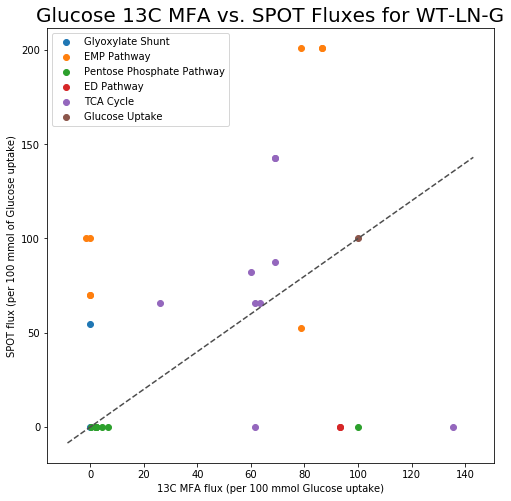

In [32]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='SPOT', linename='WT-LN-G', strain='WT')

In [33]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

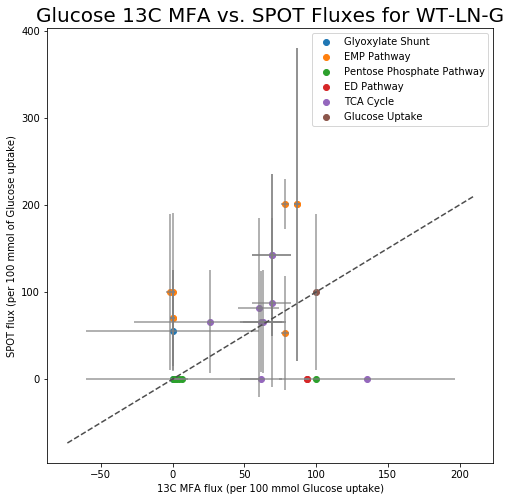

In [34]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='SPOT',linename='WT-LN-G', strain='WT')

##### **EVOL33-LN-G**

In [37]:
spotsol_evol33, spotsol_std_evol33 = spot_pred_for_three_reps(model, df_Trans, 'EVOL33-LN-G-R1', 'EVOL33-LN-G-R2','EVOL33-LN-G-R3', 'glucose')

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

##### **Save solution to data frame**

In [38]:
spotsoldf_evol33 = pd.DataFrame(spotsol_evol33, columns=['fluxes'])
spotsolstddf_evol33 = pd.DataFrame(spotsol_std_evol33, columns=['stds'])

##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [39]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, spotsoldf_evol33, spotsolstddf_evol33, 'glucose', 'SPOT', 'EVOL33')

In [40]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value,SPOT EVOL33 Value,SPOT EVOL33 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-4.704921e+01,100.000000,-4.356948e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,100.111380,4.711852e+01,100.087173,4.354608e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,70.053126,2.905634e+01,70.042595,2.710639e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,70.039669,2.905551e+01,70.031994,2.710869e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,100.385606,4.723928e+01,100.314984,4.345712e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,200.799913,9.448140e+01,200.660257,8.688614e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,200.799913,-9.448140e+01,200.660257,-8.688614e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,200.799841,-1.492782e+01,200.658285,-1.475124e+01
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,52.540789,3.447987e+01,61.598882,2.600547e+01
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-0.041768,1.031310e-06,-0.032215,2.208747e-06


#### Plot SPOT vs 13C MFA

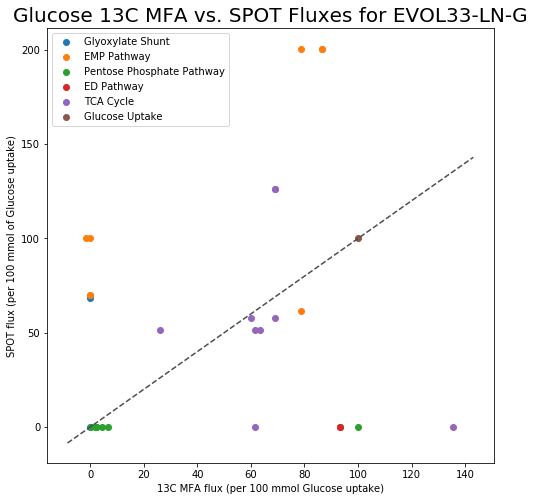

In [41]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='SPOT', linename='EVOL33-LN-G', strain= 'EVOL33')

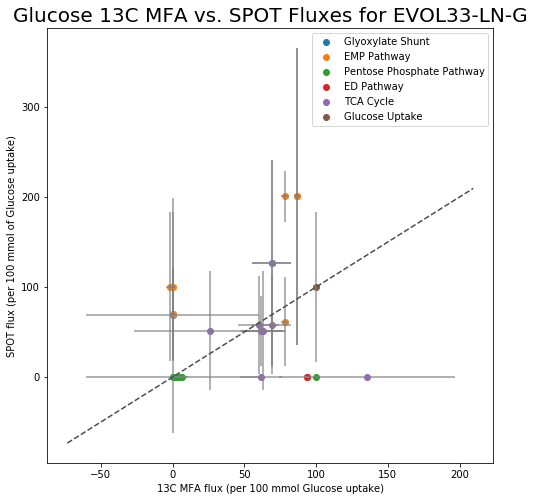

In [42]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='SPOT',linename='EVOL33-LN-G', strain='EVOL33')

##### **EVOL40-LN-G**

In [51]:
spotsol_evol40, spotsol_std_evol40 = spot_pred_for_three_reps(model, df_Trans, 'EVOL40-LN-G-R1', 'EVOL40-LN-G-R2','EVOL40-LN-G-R3', 'glucose')

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

{'EX_glc__D_e': 1000,
 'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000}

##### **Save solution to data frame**

In [52]:
spotsoldf_evol40 = pd.DataFrame(spotsol_evol40, columns=['fluxes'])
spotsolstddf_evol40 = pd.DataFrame(spotsol_std_evol40, columns=['stds'])

##### **Add  Glucose EVOL40 EFLUX2 and SPOT flux values to glucose fluxes dataframe**

In [55]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, spotsoldf_evol40, spotsolstddf_evol40, 'glucose', 'SPOT', 'EVOL40')

In [56]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value,SPOT EVOL33 Value,SPOT EVOL33 std Value,SPOT EVOL40 Value,SPOT EVOL40 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-4.704921e+01,100.000000,-4.356948e+01,100.000000,-1.638768e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,100.111380,4.711852e+01,100.087173,4.354608e+01,100.044318,1.639689e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,70.053126,2.905634e+01,70.042595,2.710639e+01,71.193811,9.126975e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,70.039669,2.905551e+01,70.031994,2.710869e+01,71.189349,9.126945e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,100.385606,4.723928e+01,100.314984,4.345712e+01,100.155482,1.640785e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,200.799913,9.448140e+01,200.660257,8.688614e+01,200.322071,3.281053e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,200.799913,-9.448140e+01,200.660257,-8.688614e+01,200.322071,-3.281053e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,200.799841,-1.492782e+01,200.658285,-1.475124e+01,200.298635,-3.032969e+00
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,52.540789,3.447987e+01,61.598882,2.600547e+01,52.893966,1.664277e+01
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-0.041768,1.031310e-06,-0.032215,2.208747e-06,-0.017503,6.949820e-07


#### Plot SPOT vs 13C MFA

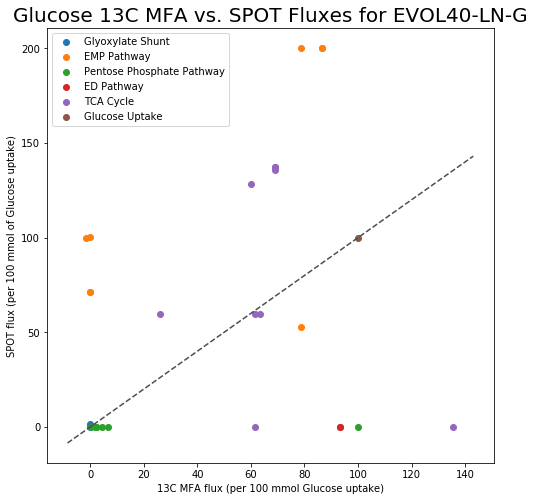

In [57]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='SPOT',linename='EVOL40-LN-G', strain='EVOL40')

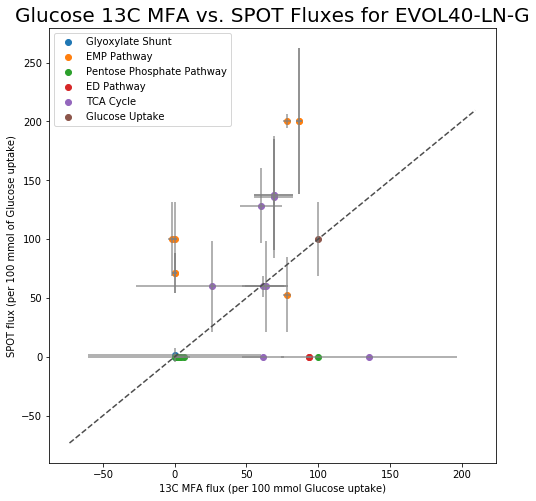

In [58]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='SPOT', linename='EVOL40-LN-G', strain='EVOL40')

### Map glucose SPOT fluxes

In [59]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if pd.isnull(row['Location on map'])!=True:
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)
    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

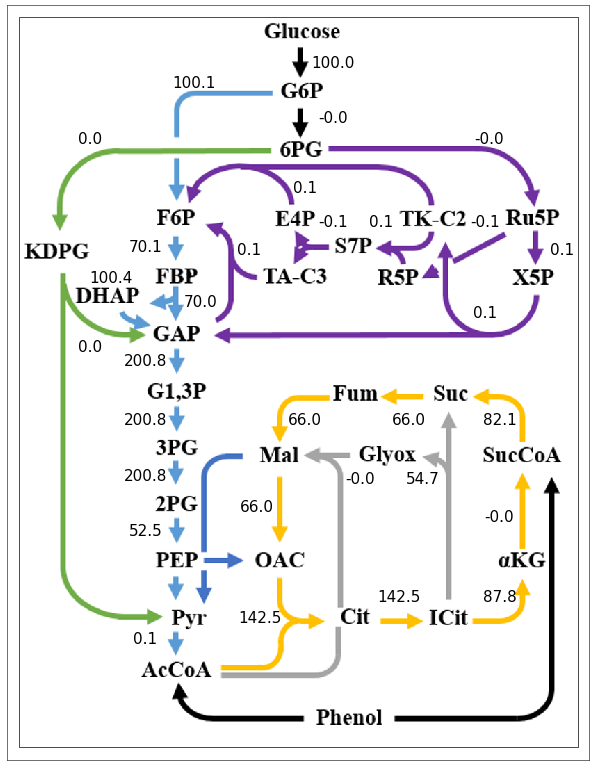

In [60]:
map_flux_results(obspred_fluxes, 'SPOT WT Value')

### Get r<sup>2</sup>  values 

In [61]:
# remove Energy molecule reactions as they are outliers
r_squared_df = glucose_fluxes[~glucose_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]

_, _, Spot_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['SPOT WT Value'])

print(f'SPOT vs 13C-MFA r-squared: {Spot_r**2:.4F}')

SPOT vs 13C-MFA r-squared: 0.0993


In [62]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value,SPOT EVOL33 Value,SPOT EVOL33 std Value,SPOT EVOL40 Value,SPOT EVOL40 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,-4.704921e+01,100.000000,-4.356948e+01,100.000000,-1.638768e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,100.111380,4.711852e+01,100.087173,4.354608e+01,100.044318,1.639689e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,70.053126,2.905634e+01,70.042595,2.710639e+01,71.193811,9.126975e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,70.039669,2.905551e+01,70.031994,2.710869e+01,71.189349,9.126945e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,100.385606,4.723928e+01,100.314984,4.345712e+01,100.155482,1.640785e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,200.799913,9.448140e+01,200.660257,8.688614e+01,200.322071,3.281053e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,200.799913,-9.448140e+01,200.660257,-8.688614e+01,200.322071,-3.281053e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,200.799841,-1.492782e+01,200.658285,-1.475124e+01,200.298635,-3.032969e+00
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,52.540789,3.447987e+01,61.598882,2.600547e+01,52.893966,1.664277e+01
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-0.041768,1.031310e-06,-0.032215,2.208747e-06,-0.017503,6.949820e-07


#### Load observed growth rates and plot glucose growth rates

In [63]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data.csv', index_col=0)
consumption_and_growth_data

,substrate consumption rate,substrate consumption rate std dev,growth rate,growth rate std dev,yield coefficient,yield coefficient std dev
Yoneda WT 1.5 g/L Phenol,0.703,0.033,0.019,0.001,0.027,0.003
Yoneda Evol33 1.5 g/L Phenol,1.014,0.021,0.034,0.002,0.033,0.002
Yoneda Evol40 1.5 g/L Phenol,0.943,0.030,0.034,0.001,0.036,0.002
"Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.027,0.000,0.032,0.000,1.150,0.000
"Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.043,0.000,0.031,0.000,0.726,0.000
"Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",-0.063,0.000,0.031,0.000,-0.500,0.000
"Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.021,0.000,0.039,0.000,1.834,0.000
"Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.033,0.000,0.033,0.000,1.006,0.000
"Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.017,0.000,0.034,0.000,2.029,0.000
Henson WT 0.5 g/L Phenol,1.422,0.129,0.065,0.001,0.046,0.005


In [64]:
new_index = pd.Series(['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P'])
consumption_and_growth_data = consumption_and_growth_data.set_index([new_index])

##### **For comparison of predicted and observed growth rates: scale predicted growth rate by multiplying with (observed substrate uptake / predicted substrate uptake)**

In [65]:
def scalegrowthtosub(solgrowth, soluptake, sub_uptake_2comp):
    factor = abs(sub_uptake_2comp/(-soluptake))
    solgrowthnew = solgrowth*factor
    return solgrowthnew

In [66]:
scaledgrowthratespot_wtlng = scalegrowthtosub(spotsoldf.loc['Growth_Glucose',:].values[0], spotsoldf.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['WT-LN-G', 'substrate consumption rate'])
scaledgrowthratespot_evol33lng = scalegrowthtosub(spotsoldf_evol33.loc['Growth_Glucose',:].values[0], spotsoldf_evol33.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL33-LN-G',  'substrate consumption rate'])
scaledgrowthratespot_evol40lng = scalegrowthtosub(spotsoldf_evol40.loc['Growth_Glucose',:].values[0], spotsoldf_evol40.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL40-LN-G',  'substrate consumption rate'])

In [67]:
allgrowthrates=pd.DataFrame(index=['WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], columns=['Growth_Glucose_SPOT' ], dtype=float)
allgrowthrates.at['WT-LN-G','Growth_Glucose_SPOT'] = scaledgrowthratespot_wtlng
allgrowthrates.at['EVOL33-LN-G','Growth_Glucose_SPOT'] = scaledgrowthratespot_evol33lng
allgrowthrates.at['EVOL40-LN-G','Growth_Glucose_SPOT'] = scaledgrowthratespot_evol40lng

In [68]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
        
    #calculate statistical quantities:
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    
    #r2_1 = round(1 - rss / tss,2) #other way to calculate rsquared
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)

    #r2 = round(r2_score(observed, predicted),2) #other way to calculate rsquared
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    mae_score = round(maefunc(observed, predicted),2)
    
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [69]:
new_index = pd.Series(['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P'])
consumption_and_growth_data = consumption_and_growth_data.set_index([new_index])


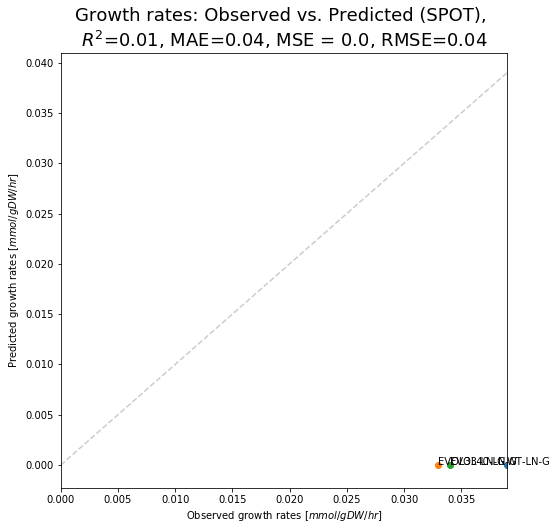

In [70]:
allindices=[str(row) for row in allgrowthrates.index]
scatterplotcompare(consumption_and_growth_data.loc[allindices, 'growth rate'], allgrowthrates.loc[:,'Growth_Glucose_SPOT'], allindices, 'SPOT')

In [71]:
allgrowthrates.to_csv('allgrowthratesGlucose.csv', index=True, header= True)